In [1]:
import numpy as np
import scanpy as sc
import scvi
from matplotlib import pyplot as plt

Global seed set to 0


In [2]:
adata_multi = sc.read_h5ad("/mnt/data0/halo/openproblem/BMMC_data.h5ad")
adata_multi.X = adata_multi.layers['counts']
newadata = adata_multi[adata_multi.obs['GEX_pseudotime_order'].notna()].copy()
adata_mvi = scvi.data.organize_multiome_anndatas(newadata)
all_clusters = ['HSC','MK/E prog','Proerythroblast','Erythroblast','Normoblast']
adata_mvi.obs['cell_type'] = adata_mvi.obs['cell_type'].cat.reorder_categories(all_clusters)
colors = ["#a82203","#208cc0","#f1af3a","#cf5e4e","#637b31"]

In [3]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key="batch")

vae = scvi.model.MULTIVI(adata_mvi,
     n_genes=(adata_mvi.var['feature_types']=='GEX').sum(),
    n_regions=(adata_mvi.var['feature_types']=='ATAC').sum())
vae.train(batch_size=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


Epoch 32/500:   6%|▌         | 31/500 [06:50<1:44:41, 13.39s/it, loss=7.93e+03, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [4]:
vae.save("Neurips_Multivi")

In [2]:
adata = sc.read_h5ad("data/datasets/mouse_hair_multi_omics.h5ad")


In [3]:
adata

AnnData object with n_obs × n_vars = 6436 × 113615
    obs: 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'chromepot', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'epxr_latent_10', 'epxr_latent_11', 'epxr_latent_12', 'epxr_latent_13', 'epxr_latent_14', 'epxr_latent_15', 'epxr_latent_16', 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'atac_latent_10', 'atac_latent_11', 'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19'
    var: 'feature_types', 'modality', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'umap'
    obsm: 'X_mvi', 'X_scMVP', 'X_

In [6]:
latent = vae.get_latent_representation()
adata_mvi.obsm["X_mvi"] = latent

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


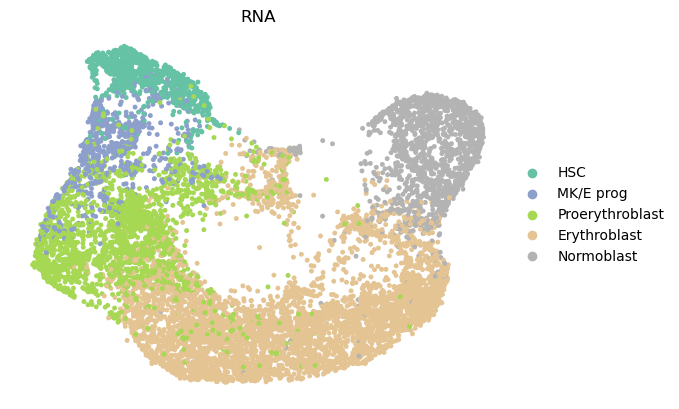

In [7]:
sc.pp.neighbors(adata_mvi, use_rep = 'X_mvi',n_neighbors=30, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.5, negative_sample_rate=0.1, spread=10)
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=['cell_type'], title="RNA",palette="Set2")

In [9]:
import scib

In [10]:
scib.metrics.graph_connectivity(adata_mvi, "cell_type")

0.9942810200303945

In [11]:
results = scib.metrics.silhouette_batch(adata_mvi, "batch",  "cell_type","X_mvi")


mean silhouette per group:                  silhouette_score
group                            
Erythroblast             0.856383
HSC                      0.785609
MK/E prog                0.855500
Normoblast               0.842582
Proerythroblast          0.837802


In [12]:
results

0.8355751484468323

In [13]:
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
batchlist= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()

In [14]:
from complementary_models import dHSIC

dHSIC(latent, batchlist)

0.009463345654958434

In [41]:
adata_mvi.var['feature_types'] = adata_mvi.var['feature_types'].cat.add_categories(["Gene Expression"])
adata_mvi.var.loc[adata_mvi.var.feature_types=="GEX","feature_types"] = "Gene Expression"

# adata_mvi.var[adata_mvi.var.feature_types=="GEX"].loc[:, "feature_types"] = "Gene Expression"

In [43]:
adata_mvi.var['feature_types'] = adata_mvi.var['feature_types'].cat.add_categories(["Peaks"])
adata_mvi.var.loc[adata_mvi.var.feature_types=="ATAC","feature_types"] = "Peaks"

In [44]:
from complementary_models import split_atac, split_rna


rnadata = split_rna(adata_mvi,  modality="feature_types")

In [45]:
rnadata

AnnData object with n_obs × n_vars = 10862 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality', '_scvi_batch'
    var: 'feature_types', 'gene_id'

In [46]:
atacdata = split_atac(adata_mvi,  modality="feature_types")

In [47]:
atacdata

AnnData object with n_obs × n_vars = 10862 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality', '_scvi_batch'
    var: 'feature_types', 'gene_id'

In [48]:
rnadata.write_h5ad("data/datasets/neurips_rna.h5ad")
atacdata.write_h5ad("data/datasets/neurips_atac.h5ad")


### SCMVP